## Задание 4.
Рассмотрим датасет по предсказанию года создания песни по числовым признакам.
Информацию о датасете можно найти здесь: 
- https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD#
- http://labrosa.ee.columbia.edu/millionsong
- https://en.wikipedia.org/wiki/Timbre

**Ссылка**: https://www.kaggle.com/t/c55b0b2354bd4ca5ac83fe5ed8b3eb92

Мы используем поднабор этого датасета. Пожалуйста, не используйте исходный датасет для читинга, за это получите 0 за ВООБЩЕ всю домашку. Это задание организовано с помощью соревнования на kaggle.
Попробуйте обучить нейронную сеть (используя линейные и другие слои, возможную нормализацию и активации). Можете использовать любые методы предобработки данных и фокусы, 
кроме ансамблирования и использования сторонних источников ДАННЫХ.
- Задание обязательно, базовое максимальное число баллов - 6. 
- Топ 25% получат +3 балла, топ 50 +2 балла, топ 75 +1 балл.
- Решение должно быть уникальным, необходимо предоставить код и описание решения. Если использованы внешние источники (туториалы, статьи и т.п.), необходимо предоставить ссылки.
- Обучите модель, используя ваш кастомный оптимизатор. Это даст еще 1 балл. Покажите, изменилось ли что-то.
- При решении задачи можно использовать любые встренные в torch модули (nn, optim, transforms, etc)
- Можно использовать numpy, sklearn, pandas ТОЛЬКО для предобработки и постобработки решения (сборки сабмишена). Для самой модели можно использовать только torch.
- При переобучении можно добавить dropout, batchnorm итд. 

# Предобработка
[Источник вдохновления](https://www.kaggle.com/code/raghav1810/release-year-prediction-on-msd-using-neural-nets)

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


df_x = pd.read_csv("../../datasets/YearPredictionMSD/train_x.csv", index_col=[0]) #, sep=","
df_y = pd.read_csv("../../datasets/YearPredictionMSD/train_y.csv", index_col=[0])
df = pd.merge(df_x, df_y, left_index=True, right_index=True)

#df.info()

In [96]:
df.describe()
#df.to_csv("df_describe()", sep='\t', index = False)


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,year
count,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,...,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,43.394558,1.540279,8.378243,1.315349,-6.476035,-9.503415,-2.243164,-1.660698,3.543946,1.892996,...,-72.008182,41.154440,37.892338,0.145765,17.576243,-28.502296,4.474666,17.717701,1.227647,1998.366714
std,6.074562,51.578894,35.742553,16.622971,22.823521,12.926176,14.700348,8.035388,10.629817,6.602191,...,171.932584,120.075095,96.748418,16.162963,115.706029,180.463987,13.592096,185.335542,22.018997,11.048088
min,7.199890,-302.031900,-257.525600,-120.723150,-142.160680,-60.198620,-100.602550,-51.443820,-75.539550,-31.344160,...,-1976.846950,-791.832320,-1237.931680,-227.608010,-2678.193680,-3059.906060,-100.618700,-5000.654060,-286.031200,1922.000000
25%,39.970260,-25.603507,-11.773080,-8.490435,-20.716735,-18.524397,-10.651808,-6.402985,-2.573275,-2.446435,...,-138.560657,-21.424297,-4.443660,-7.027105,-32.236598,-101.305695,-2.563620,-60.364940,-8.873683,1994.000000
50%,44.282770,8.800720,10.226865,-0.582025,-5.808040,-11.254920,-2.007255,-1.516640,3.658655,1.763500,...,-52.984525,29.218730,33.576620,0.770135,15.522650,-22.050410,3.021435,6.982460,-0.050725,2002.000000
75%,47.843418,36.610743,29.596557,9.035892,7.858092,-2.198952,6.725500,3.111740,9.935210,6.245860,...,14.405743,89.374030,78.710667,8.380725,66.429958,50.378898,9.912000,86.542642,9.664982,2006.000000
max,57.408630,240.617010,318.868960,143.841600,142.305480,68.300090,147.965260,52.331120,78.149440,36.596180,...,1081.951340,1473.745210,1458.580210,199.121500,1620.749740,1879.332480,352.359540,3165.372860,245.209770,2011.000000


In [97]:
corr_matrix = df.corr()
corr_matrix

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,year
0,1.000000,0.566384,0.238219,0.015581,-0.290998,-0.255993,0.150465,-0.056922,0.218639,0.100482,...,0.185610,-0.141162,0.043386,0.131090,-0.023281,0.060050,-0.151631,-0.090429,-0.181318,0.231402
1,0.566384,1.000000,0.003449,0.108685,-0.176475,-0.118153,0.093488,0.110959,0.139684,0.381411,...,0.068017,-0.160104,0.025871,0.147906,0.052706,0.001514,-0.020335,-0.117093,-0.143765,0.027011
2,0.238219,0.003449,1.000000,0.141888,-0.120211,0.058324,-0.056112,0.084467,0.032342,-0.103261,...,0.176158,0.105282,-0.013705,-0.038581,-0.103733,0.083694,-0.078674,-0.090521,0.096694,-0.142195
3,0.015581,0.108685,0.141888,1.000000,0.041031,0.316875,0.276893,0.033091,-0.068800,0.158218,...,-0.103787,0.064347,0.081510,-0.082989,0.065558,0.024398,0.263893,0.042521,0.004551,0.015034
4,-0.290998,-0.176475,-0.120211,0.041031,1.000000,0.012747,-0.099421,-0.004039,-0.218758,-0.090853,...,-0.094841,0.025572,-0.023188,0.013525,0.001245,-0.029810,-0.015504,-0.009246,0.031752,0.005840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.060050,0.001514,0.083694,0.024398,-0.029810,-0.030335,0.024270,0.020748,0.057749,0.021375,...,-0.015066,0.160687,0.360869,0.020517,0.015611,1.000000,-0.016337,0.182361,0.216426,0.021897
87,-0.151631,-0.020335,-0.078674,0.263893,-0.015504,0.137150,0.087998,0.047344,0.003349,0.068824,...,0.002216,0.267372,0.008950,-0.233718,0.091228,-0.016337,1.000000,0.058742,0.228683,-0.017512
88,-0.090429,-0.117093,-0.090521,0.042521,-0.009246,-0.003068,0.091808,-0.010945,0.024786,-0.021552,...,-0.064811,0.077995,0.127760,-0.017652,0.180202,0.182361,0.058742,1.000000,0.168630,0.005741
89,-0.181318,-0.143765,0.096694,0.004551,0.031752,0.019502,-0.067506,0.059553,0.048917,0.016578,...,-0.019252,0.090612,-0.029815,-0.155303,-0.025547,0.216426,0.228683,0.168630,1.000000,-0.050458


Text(0, 0.5, 'Number of songs')

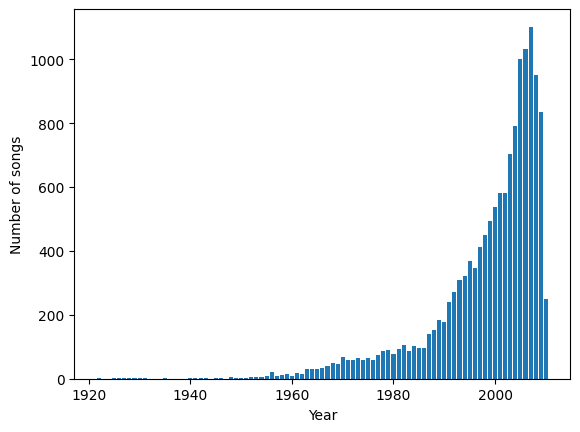

In [98]:
nsongs = {}
for y in range(1922,2012):
    nsongs[y] = len(df[df.year==y])
yrs = range(1922,2011)
values = [nsongs[y] for y in yrs]
plt.bar(yrs, values, align='center')
plt.xlabel("Year")
plt.ylabel("Number of songs")

In [99]:
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:, 0:90], df_y["year"], test_size=0.3)
X_train

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
91760,45.46530,75.45026,35.47050,2.95624,-19.71282,2.89321,7.77444,3.78676,-5.32777,-0.01938,...,17.23378,27.19400,25.61453,36.30716,10.83426,-0.17645,-75.96021,7.17215,27.33528,5.15809
91369,46.62819,9.90625,16.37036,-5.59028,-31.03397,-21.84424,14.85164,5.76408,21.08988,10.97875,...,-46.51487,42.38361,52.68072,-12.32147,5.62891,-6.79621,-12.19250,3.80050,324.37311,30.46507
252079,40.18896,-34.45273,14.01492,2.41669,-24.71461,0.99973,-8.10141,-10.29385,5.54575,-4.24138,...,14.63288,-116.97684,-13.67563,-22.74521,11.06194,6.17129,7.35682,-11.32322,-54.77686,-11.11203
444856,38.54147,47.70578,28.53514,19.99441,-7.08553,-6.66930,-0.38035,1.43341,-11.50862,4.06733,...,7.98866,-215.72206,-107.01376,103.22619,-2.79405,-31.75290,-80.37151,8.28595,103.31381,1.93217
324497,53.60781,37.13907,-1.11425,16.71224,21.01561,-21.00132,7.63646,2.46501,1.59013,9.28488,...,-7.19041,-132.61324,-52.45465,-3.50508,9.49213,-29.86827,-146.99808,-17.49415,-29.14021,-28.58531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505513,36.30192,16.14399,63.81001,11.62573,7.08731,32.35446,-44.79767,-0.76175,1.83869,9.03123,...,20.91729,-113.00219,256.89098,64.26000,29.16705,68.41382,23.01293,-3.80363,40.25667,-15.91831
215475,49.66914,44.91246,-22.12116,-18.58574,-2.69059,-29.05889,-4.67774,-1.94542,4.26079,1.01704,...,4.79795,-70.57352,-43.46799,-9.73019,-1.47315,29.21690,-72.31892,8.90277,194.21148,2.42360
219954,37.28237,-79.66959,91.42166,2.39973,15.16975,-1.40565,-38.82533,-7.95218,8.85991,-8.50413,...,94.91744,-334.86204,207.11738,-56.65323,-9.09471,-37.80197,-470.48789,13.57016,18.28176,7.66985
337570,43.86913,-0.20153,36.46604,-2.86395,21.35272,-17.25184,-13.24762,-2.94265,4.54526,2.25322,...,20.19795,-128.57375,-29.20243,96.05717,2.34277,-17.52861,155.24947,6.18787,-70.94871,-0.95426


In [100]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the train set and the test set.
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_train_std = pd.DataFrame(X_train_std,columns=X_train.columns)


In [101]:
# Make an instance of the Model
pca = PCA(.90)

# We fit to only our training set
pca.fit(X_train_std)
# Print number of components generated
pca.n_components_

54

In [102]:
X_train_proc = torch.tensor(pca.transform(X_train_std), dtype=torch.float)
X_test_proc = torch.tensor(pca.transform(X_test_std), dtype=torch.float)

/home/dima/Документы/Першин_Никольская_Нейронные_сети/myvenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [103]:
Y_train_proc = Y_train - min(Y_train)
Y_test_proc = Y_test - min(Y_test)

In [104]:
Y_train_hot = torch.tensor(to_categorical(Y_train_proc, 90), dtype=torch.uint8)
Y_test_hot = torch.tensor(to_categorical(Y_test_proc, 90), dtype=torch.uint8)

In [105]:
print(X_train_proc.shape)
print(Y_test_hot.shape)

torch.Size([9800, 54])
torch.Size([4200, 90])


# Нейросеть
[Источник вдохновления](https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/)

In [106]:
import torch.nn as nn


class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(54, 100)
        self.act = nn.ReLU()
#        self.hidden = nn.Linear(100, 100)
#        self.act = nn.ReLU()
        self.output = nn.Linear(100, 90)
        self.act = nn.Softmax()
        
    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

model = Multiclass()

In [107]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


In [108]:
for n in range(10):
    y_pred = model(X_train_proc)
    loss = loss_fn(y_pred, Y_train_hot)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

AttributeError: 'Multiclass' object has no attribute 'hidden'

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(output, label)